In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/README.dataset.txt
/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/README.roboflow.txt
/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/valid/Screenshot-2021-11-22-015719_png.rf.1249e055decfe04367817c3073d0df10.jpg
/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/valid/Screen-Shot-2021-10-15-at-11-47-35-AM_png.rf.a5deec471bfa070dc294e51397bf7863.jpg
/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/valid/Screen-Shot-2021-11-15-at-12-54-09-PM_png.rf.aa53a181b86d5c881e3d1e41289eb867.jpg
/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/valid/Screen-Shot-2021-11-22-at-10-00-45-AM_png.rf.bdb3b5934bd8b28b50d83c2a042938c2.jpg
/kaggle/input/nail-images/dataset/Nail Disease Detection.v1-raw_dataset.multiclass/valid/Screenshot-2021-11-22-204723_pn

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
image_shape = (224, 224, 3)

dataset = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/nail-images/dataset/v4",
    image_size=image_shape[:2],
)

x, y = [], []
for batch in dataset.take(-1):
    images, labels = batch
    x.append(images.numpy())
    y.append(labels.numpy())

x = np.concatenate(x)
y = np.concatenate(y)

Found 3080 files belonging to 10 classes.


In [14]:
dataset.class_names

['Acral Lentiginous Melanoma',
 'Beaus Line',
 'Blue Finger',
 'Clubbing',
 'Healthy Nail',
 'Koilonychia',
 'Muehrckes Lines',
 'Onychogryphosis',
 'Pitting',
 'Terry-s Nail']

In [15]:
class_names = dataset.class_names
num_classes = len(class_names)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

In [16]:
print(
    f"total  : {np.unique(y, return_counts=True)[1]}\n"
    f"y_train: {np.unique(y_train, return_counts=True)[1]}\n"
    f"y_val  : {np.unique(y_val, return_counts=True)[1]}\n"
    f"y_test : {np.unique(y_test, return_counts=True)[1]}"
)

total  : [357 218 292 373 358 260 159 329 312 422]
y_train: [286 174 234 298 286 208 127 263 250 338]
y_val  : [35 22 29 38 36 26 16 33 31 42]
y_test : [36 22 29 37 36 26 16 33 31 42]


In [17]:
def plot_loss_and_accuracy(history) -> None:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="Train")
    ax1.plot(history.history["val_loss"], label="Validation")
    ax1.legend(loc="best")

    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="Train")
    ax2.plot(history.history["val_accuracy"], label="Validation")
    ax2.legend(loc="best")

    plt.show()

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # degree
    horizontal_flip=True,
    vertical_flip=True,
)

datagen.fit(x_train)

In [19]:
from tensorflow import keras

base_model = tf.keras.applications.MobileNetV3Large(input_shape=image_shape, include_top=False)
# base_model = keras.models.load_model("/kaggle/input/mobilenetv3/weights_mobilenet_v3_large_224_1.0_float_no_top_v2.h5")
base_model.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [20]:
inputs = tf.keras.Input(shape=image_shape)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-4)

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [22]:
batch_size = 4
epochs = 50

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                    validation_data=(x_val, y_val)

Epoch 1/50
616/616 [==============================] - 65s 99ms/step - loss: 1.5378 - accuracy: 0.4984 - val_loss: 1.0899 - val_accuracy: 0.6364
Epoch 2/50
616/616 [==============================] - 59s 96ms/step - loss: 0.9499 - accuracy: 0.7041 - val_loss: 0.8763 - val_accuracy: 0.7175
Epoch 3/50
616/616 [==============================] - 60s 97ms/step - loss: 0.7715 - accuracy: 0.7593 - val_loss: 0.7804 - val_accuracy: 0.7338
Epoch 4/50
616/616 [==============================] - 64s 103ms/step - loss: 0.6748 - accuracy: 0.7886 - val_loss: 0.7450 - val_accuracy: 0.7695
Epoch 5/50
616/616 [==============================] - 63s 102ms/step - loss: 0.6022 - accuracy: 0.8170 - val_loss: 0.6974 - val_accuracy: 0.7890
Epoch 6/50
616/616 [==============================] - 59s 95ms/step - loss: 0.5391 - accuracy: 0.8364 - val_loss: 0.6442 - val_accuracy: 0.8182
Epoch 7/50
616/616 [==============================] - 58s 95ms/step - loss: 0.4940 - accuracy: 0.8478 - val_loss: 0.6385 - val_accurac

loss=0.4497, accuracy=0.8604


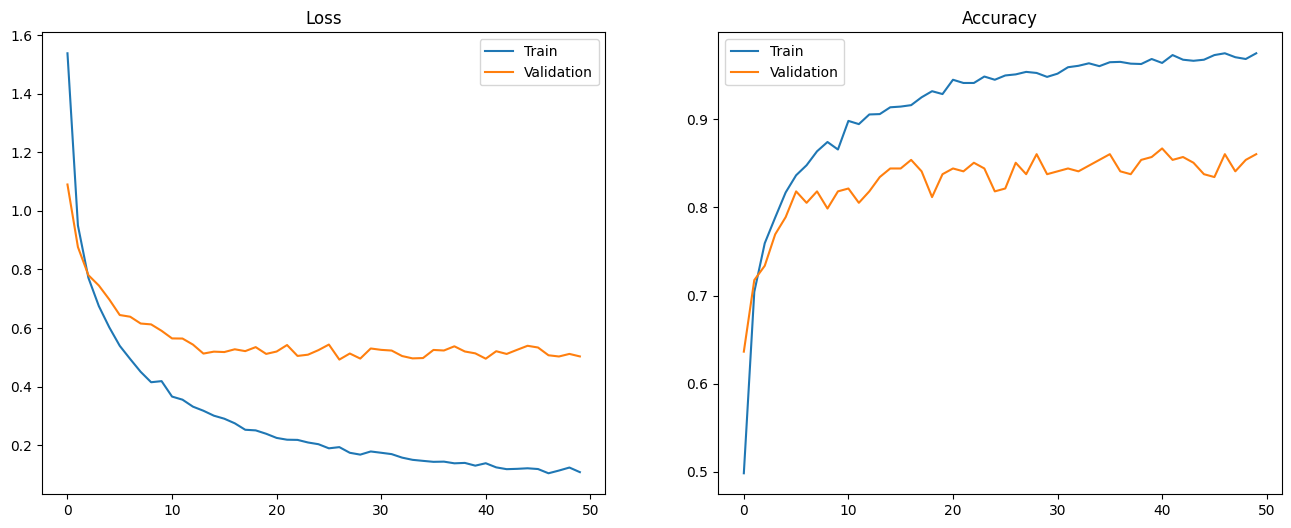

In [23]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"{loss=:.4f}, {accuracy=:.4f}")
plot_loss_and_accuracy(history)

In [24]:
ISSUES_MAPPING = {
    "Acral Lentiginous Melanoma": "Acral Lentiginous Melanoma (ALM) is a rare form of skin cancer.",
    "Beaus Line": "Uncontrolled diabetes, peripheral vascular disease, zinc deficiency, illnesses associated with a high fever.",
    "Blue Finger": "Insufficient oxygen in blood, cold environment.",
    "Clubbing": "Lung or heart related diseases, mostly lung cancer.",
    "Healthy Nail": "No cause. Your nail is healthy. Congratulations!",
    "Koilonychia": "Too much or too low iron level, uncontrolled diabetes, heart disease, celiac disease, and celiac cancer.",
    "Muehrckes Lines": "Lack of nutrients, kidney disease, liver disease, cancer after chemotherapy.",
    "Onychogryphosis": "Foot trauma, fungal infection, autoimmune disease, peripheral vascular disease, ichthyosis.",
    "Pitting": "Connective tissue disorders, autoimmune disease, genetic disorder.",
    "Terry-s Nail": "Cirrhosis, heart failure, diabetes, kidney failure, viral hepatitis.",
}

In [25]:
def predict(img, top_n=3):
    image = read_image(img) if isinstance(img, str) else img
    result = make_prediction(image, top_n=top_n)
    show_possible_health_issues(result)

    plt.imshow(image.astype("uint8"))
    plt.show()


def read_image(image_path):
    image = tf.keras.utils.load_img(image_path, target_size=image_shape[:2])
    return tf.keras.utils.img_to_array(image)


def make_prediction(image, top_n=3):
    [pred] = model.predict(np.expand_dims(image, axis=0), verbose=0)
    return [(class_names[idx], pred[idx]) for idx in pred.argsort()[::-1]][:top_n]


def show_possible_health_issues(result):
    for nail_disease, prob in result:
        print(f"({prob * 100:.2f}%) {nail_disease}")
        print(f"\tPossible cause: {ISSUES_MAPPING.get(nail_disease)}", end="\n\n")

(46.81%) Beaus Line
	Possible cause: Uncontrolled diabetes, peripheral vascular disease, zinc deficiency, illnesses associated with a high fever.

(38.19%) Healthy Nail
	Possible cause: No cause. Your nail is healthy. Congratulations!

(8.16%) Pitting
	Possible cause: Connective tissue disorders, autoimmune disease, genetic disorder.



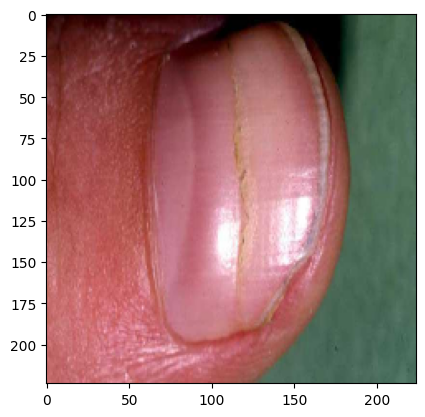

In [26]:
path = "/kaggle/input/nail-images/dataset/v3/Beaus Line/766x415_SLIDE_1_Nail_Abnormalities_jpg.rf.69ed5ce6c18e5c33eabafb96c78ce399.jpg"
predict(path)

In [3]:
model_path = "saved_models/model_0.7597"

In [4]:
model.save(model_path)

NameError: name 'model' is not defined